## Digital soil mapping of clay content 

In this tutorial, my goal is to present an easy way to estimate clay content using digital soil mapping approaches. For this, a dataset with n samples with the clay content determined in the laboratory will be used as the target variable to be predicted over an area of n ha. As features, a median reflectance satellite image (Landsat) representing the bare surfaces will be used. This bare soil image was obtained following the [GEOS3 method](https://www.sciencedirect.com/science/article/pii/S0034425718302049), developed by Demattê and colaborators and published in the Remote Sensing of Environment Journal. The bare soil image has six spectral bands in the vis-NIR-SWIR region. We will not use other environmental covariates such as terrain or climate variables, which are known factors that affect soil formation. This is due that satellite images were demonstrated to predict accurately clay content and our objective here is simply to explain the process involved in digital mapping of soil clay content.  

Further improvements can be added in terms of new variables as needed.


In [165]:
## Import libraries
import shap
import rasterio
import geopandas
import folium
import dalex as dx
import numpy as np
import pandas as pd
import seaborn as sns
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt

from glob import glob
from pprint import pprint
from shapely.geometry import Point
from osgeo import gdal, ogr, gdal_array
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from rasterio.plot import show, show_hist, reshape_as_raster, reshape_as_image
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [166]:
### Load dataset
dat_clay = pd.read_csv('dataset.csv', sep=';')
dat_clay.head()

,X,Y,Clay.gkg,OM.gkg
0,-47.431591,-22.773409,301,22.21
1,-47.449435,-22.841908,503,25.02
2,-47.378210,-22.856072,120,15.00
3,-47.375972,-22.864430,128,8.00
4,-47.372973,-22.868192,117,11.00


In [167]:
### Basic statistics of the target variable
dat_clay.describe().T.style

,count,mean,std,min,25%,50%,75%,max
X,388.000000,-47.405859,0.028572,-47.457000,-47.429812,-47.402296,-47.384326,-47.345924
Y,388.000000,-22.865197,0.029960,-22.907360,-22.889000,-22.874463,-22.842459,-22.773409
Clay.gkg,388.000000,267.840206,161.258360,13.000000,124.000000,234.500000,418.500000,638.000000
OM.gkg,388.000000,18.600335,6.365130,5.800000,13.200000,17.900000,23.025000,39.000000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


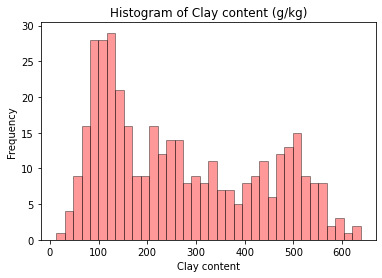

In [168]:
### Plotting histograms and density plots
sns.distplot(dat_clay['Clay.gkg'], hist = True, kde = False, bins = int(180/5), color = 'red', hist_kws = {'edgecolor': 'black'})
plt.title('Histogram of Clay content (g/kg)')
plt.xlabel('Clay content')
plt.ylabel('Frequency')
plt.show()

In [169]:
## Convert pandas dataframe into geopandas
geo = [Point(xy) for xy in zip(dat_clay['X'], dat_clay['Y'])]
CRS = {'init': 'epsg:4326'}
dat_clay_gpd = geopandas.GeoDataFrame(dat_clay, crs=CRS, geometry=geo)
dat_clay_gpd.head()

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


,X,Y,Clay.gkg,OM.gkg,geometry
0,-47.431591,-22.773409,301,22.21,POINT (-47.43159 -22.77341)
1,-47.449435,-22.841908,503,25.02,POINT (-47.44944 -22.84191)
2,-47.378210,-22.856072,120,15.00,POINT (-47.37821 -22.85607)
3,-47.375972,-22.864430,128,8.00,POINT (-47.37597 -22.86443)
4,-47.372973,-22.868192,117,11.00,POINT (-47.37297 -22.86819)


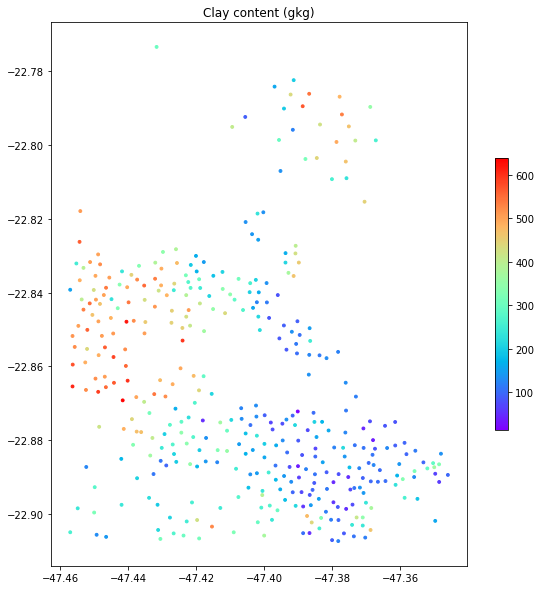

In [170]:
## Plot the points 
fig, ax = plt.subplots(figsize = (10,10))
dat_clay_gpd.plot(column= 'Clay.gkg', ax = ax, marker='o', markersize = 8, cmap = 'rainbow', legend=True, legend_kwds = {'shrink': 0.5})
ax.set_title('Clay content (gkg)')
plt.show()

In [157]:
## Plot in an interative base map to know where the 
coords = [-22.84, -47.4]
my_map = folium.Map(location = coords, zoom_start = 12)
folium.GeoJson(data=dat_clay_gpd["geometry"]).add_to(my_map)
my_map

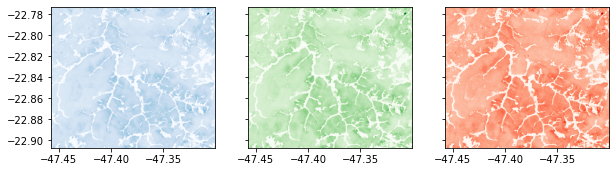

In [178]:
## Load rasters
covs = rasterio.open('SYSI.tif')

## Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,10), sharey = True)

## Plot bands
show((covs, 1), cmap = 'Blues', ax=ax1)
show((covs, 2), cmap = 'Greens', ax=ax2)
show((covs, 3), cmap = 'Reds', ax=ax3)
plt.show()

(6, 501, 582)


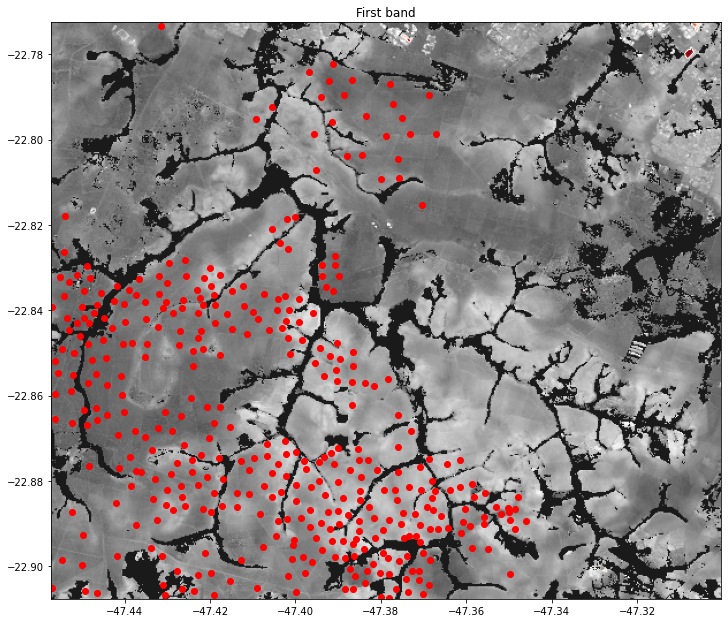

In [180]:
## RGB composite
#Read he grid values into numpy arrays
covs_arr = covs.read()
print(covs_arr.shape)

fig, ax = plt.subplots(figsize=(12,12))
dat_clay_gpd.plot(ax=ax, color='red')
show(covs, ax=ax, cmap = 'RdGy_r')
plt.title('First band')
plt.show()

In [181]:
## Extract the raster values
dat_clay_gpd.index = range(len(dat_clay_gpd))
dat_clay_gpd
coords = [(x,y) for x, y in zip(dat_clay_gpd.X, dat_clay_gpd.Y)]
dat_clay_gpd['ju'] = [x for x in covs.sample(coords)]
dat_clay_gpd

,X,Y,Clay.gkg,OM.gkg,geometry,ju
0,-47.431591,-22.773409,301,22.21,POINT (-47.43159 -22.77341),"[483, 766, 1078, 1570, 2003, 1788]"
1,-47.449435,-22.841908,503,25.02,POINT (-47.44944 -22.84191),"[418, 703, 1106, 1494, 1783, 1571]"
2,-47.378210,-22.856072,120,15.00,POINT (-47.37821 -22.85607),"[641, 1038, 1409, 2108, 2993, 2677]"
3,-47.375972,-22.864430,128,8.00,POINT (-47.37597 -22.86443),"[693, 1086, 1531, 2320, 3023, 2759]"
4,-47.372973,-22.868192,117,11.00,POINT (-47.37297 -22.86819),"[786, 1172, 1552, 2356, 3316, 3018]"
...,...,...,...,...,...,...
383,-47.385720,-22.893479,94,13.20,POINT (-47.38572 -22.89348),"[1062, 1592, 2040, 3029, 3982, 3516]"
384,-47.379980,-22.907101,91,12.00,POINT (-47.37998 -22.90710),"[882, 1337, 1724, 2634, 3667, 3254]"
385,-47.378296,-22.898116,86,11.00,POINT (-47.37830 -22.89812),"[837, 1319, 1686, 2680, 3544, 3145]"
386,-47.409350,-22.795095,404,27.00,POINT (-47.40935 -22.79509),"[586, 953, 1227, 1731, 2419, 2091]"


In [184]:
## Convert to pandas dataframe and separate the columns list
dat_clay_df = pd.DataFrame(dat_clay_gpd)
dat_split = pd.DataFrame(dat_clay_df['ju'].tolist(), columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6'])
dat_clay_df = pd.concat([dat_clay_df, dat_split], axis=1)
dat_clay_df = dat_clay_df.drop(['geometry', 'ju', 'X', 'Y'], axis=1)  ## drop all the columns that will no be used

dat_clay_df.head()

,Clay.gkg,OM.gkg,B1,B2,B3,B4,B5,B6
0,301,22.21,483,766,1078,1570,2003,1788
1,503,25.02,418,703,1106,1494,1783,1571
2,120,15.00,641,1038,1409,2108,2993,2677
3,128,8.00,693,1086,1531,2320,3023,2759
4,117,11.00,786,1172,1552,2356,3316,3018


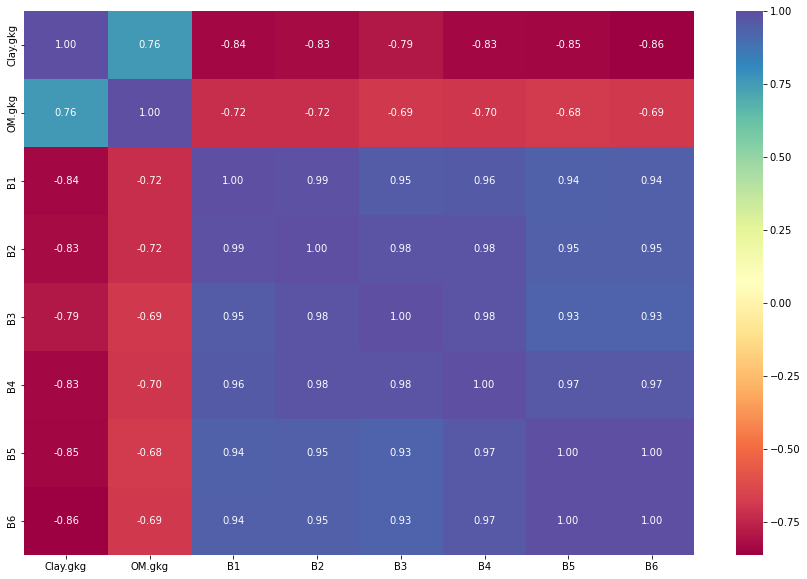

In [185]:
## Correlation analysis
dat_corr = dat_clay_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(dat_corr, cmap='Spectral', annot=True, fmt=".2f")
plt.show()


RMSE:  64.45 g/kg
Mean Absolute Error: 46.79 g/kg.
R-squared:  0.85


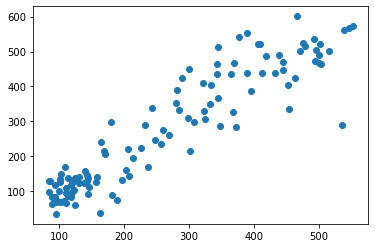

In [186]:
## Random Forest
## Separating covariates (X) from the target (y) variable
X = dat_clay_df.drop(['Clay.gkg', 'OM.gkg'], axis =1)
y = dat_clay_df[['Clay.gkg', 'OM.gkg']]
## Splitting the data into training and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


# Initializing the Random Forest Regression model with 500 decision trees for predicting clay content
model_rf = RandomForestRegressor(n_estimators = 500)

# Fitting the Random Forest Regression model to the data
model_rf.fit(x_train, y_train['Clay.gkg'])

# Predicting the target values of the test set
y_pred = model_rf.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test['Clay.gkg'], y_pred)), '.3f'))
print("\nRMSE: ", rmse, 'g/kg')

# Calculate and print out the mean absolute error (mae)
errors = abs(y_pred - y_test['Clay.gkg'])
print('Mean Absolute Error:', round(np.mean(errors), 2), 'g/kg.')

# Calculate and print R-squared
r2 = r2_score(y_test['Clay.gkg'].values.ravel(), y_pred)
print('R-squared: ', round(r2, 2))

## Plotting the results
plt.scatter(y_pred, y_test['Clay.gkg'])
plt.show()

We had a very good result with the base model, without tunning any parameter. Usually, clay content is well predicted by remote sensing images, as the reflectance values are very good correlated with clay content. Even with this good result, we're going to try some hyperparameter tunning, just to show how it works.  

In the code presented below, we first print the parameters used in the base model and then set randomly some parameters.

In [187]:
## Hyperparameter tunning
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model_rf.get_params())

# Number of trees
n_tree = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]  #np.linspace return evenly spaced number over a specified interval

# Number of features at every split
features = ['auto', 'sqrt']

# Number of leaves in each tree
depth = [int(x) for x in np.linspace(10, 100, num = 10)]
depth.append(None)

# Number of samples to split a node
samples_split = [2, 4, 6, 8, 10, 12, 14, 16]

# Number of samples at each leaf node
samples_leaf = [1, 2, 4, 6, 8, 10]

# Method of selectin sampels
bootstrap = ['True', 'False']

# Create the random grid
random_search = {'n_estimators': n_tree,
               'max_features': features,
               'max_depth': depth,
               'min_samples_split': samples_split,
               'min_samples_leaf': samples_leaf,
               'bootstrap': bootstrap}


print('\nParameters set:\n')
pprint(random_search)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Parameters set:

{'bootstrap': ['True', 'False'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6, 8, 10],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [188]:
## Run the model with the hyperparameter tuning
model_rf_tun = RandomForestRegressor()

model_rf_random = RandomizedSearchCV(estimator = model_rf_tun, param_distributions = random_search, n_iter = 50, cv = 5, verbose = 2, n_jobs = -1)

model_rf_random.fit(x_train, y_train['Clay.gkg'])

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(model_rf_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

The best parameters are: 

{'bootstrap': 'False',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 890}


#### Evaluating and comparing the models

The next step is to confirm if our model was improved after tunning the parameters. For this, we're going to compare their performances and figure it out by how much the new model improved our results. 

In [189]:
## Evaluate the hyperparameter tunning
def eval_model(model, features, target):
    predictions = model.predict(features)
    rmse = float(format(np.sqrt(mean_squared_error(target, predictions)), '.3f'))
    print ('\nPerformance')
    print('RMSE = ', rmse, 'g/kg')
    
    return rmse

# Base model - withouth tunning hyperparameters
base_rf = model_rf
base_rf.fit(x_train, y_train['Clay.gkg'])
base_acc = eval_model(base_rf, x_test, y_test['Clay.gkg'])

## Improved model
best_model = model_rf_random.best_estimator_
best_acc = eval_model(best_model, x_test, y_test['Clay.gkg'])

print('\nImprovement of {:0.2f}%. ' .format(100 * (base_acc - best_acc) / best_acc))


Performance
RMSE =  64.098 g/kg

Performance
RMSE =  65.717 g/kg

Improvement of -2.46%. 


The new hyperparameters didn't improve our performance. Let´s try a cross-validation approach

In [192]:
## Set cross-validation parameters
param_grid_cv = {'n_estimators': [500, 600, 700, 800], 'min_samples_split': [4, 6, 10, 20], 
                 'min_samples_leaf': [2, 4, 6], 'max_features': [2, 4, 6], 'max_depth': [20, 40, 80, 100], 
                 'bootstrap': [True, False]}

model_rf_cv = RandomForestRegressor()
grid_search = GridSearchCV(estimator = model_rf_cv, param_grid = param_grid_cv, cv = 5, n_jobs = -1, verbose = 2)

## Fit the grid search to the training data
grid_search.fit(x_train, y_train['Clay.gkg'])
grid_search.best_params_


## Measuring the improvement
base_acc = eval_model(base_rf, x_test, y_test['Clay.gkg'])

best_grid = grid_search.best_estimator_
grid_acc = eval_model(best_grid, x_test, y_test['Clay.gkg'])

print('\nImprovement of {:0.2f}%.'.format( 100 * (base_acc - grid_acc) / grid_acc))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits

Performance
RMSE =  64.098 g/kg

Performance
RMSE =  65.918 g/kg

Improvement of -2.76%.


With this new approach we doesn't see much improvement either. Therefore, we will continue with the base model.


RMSE:  65.717 g/kg
Mean Absolute Error: 48.63 g/kg.
R-squared:  0.85


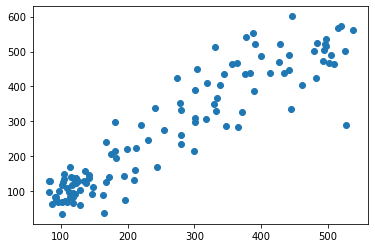

In [193]:
# Predicting the target values of the test set from the base model
y_pred_base_model = best_model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse_base_model = float(format(np.sqrt(mean_squared_error(y_test['Clay.gkg'], y_pred_base_model)), '.3f'))
print("\nRMSE: ", rmse_base_model, 'g/kg')
# Calculate the absolute errors
errors_base_model = abs(y_pred_base_model - y_test['Clay.gkg'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_base_model), 2), 'g/kg.')

# Calculate and print R-squared
r2_base_model = r2_score(y_test['Clay.gkg'].values.ravel(), y_pred_base_model)
print('R-squared: ', round(r2, 2))

## Plotting the results
plt.scatter(y_pred_base_model, y_test['Clay.gkg'])
plt.show()

We got an 85% explanation of our model by the bare soil image. Although it might seem a good result, we need to be careful with overfitting. This will be a topic for another tutorial.

Now, let's use the Shapley values to explain our models. This algorithm is based in game theory, and can be interpreted as the contribution of each variable to the model performance. In our case, the two most important variables were B1 and B6, blue and SWIR bands, respectively. In general, when they are high (red colors), the value of the target variable or clay content tends to diminsh. The opposite holds true. We are seeing that the B1 band contributes more with high values of clay content when the values of the reflectance is also high. 

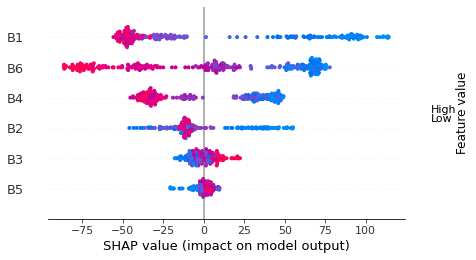

In [194]:
## Shapley values to explain RF models
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features = x_train, feature_names = x_train.columns)

Shapley values allow us to see the contribution for each observation individually. Take a look at the example presented below, for the sample number 2. The base value is 265.7 g/kg. In green are the spectral bands that contribute to lower the clay content (B1, B4 and B2). In pink, those that describe higher values of clay content. 

In [196]:
## Plot the contribution of an individual observation. In this case, the number 17
display(x_train.iloc[2])
shap.initjs()
i = 2
shap.force_plot(explainer.expected_value, shap_values[i], features=x_train.loc[i], feature_names=x_train.columns, plot_cmap="PkYg")

B1     849
B2    1308
B3    1587
B4    2263
B5    2947
B6    2558
Name: 124, dtype: int16

Finally, let's make our predictions to the entire area. Differently from R, where you can use the raster format to predict the whole area, here in python you should first convert the images to array, reshape (row*col, number of bands) to allow the predictions and then reshape it again before saving. 

In [197]:
## load image data
img_RS = 'SYSI.tif'

image = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((image.RasterYSize, image.RasterXSize, image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()
    

## Set the number of columns, rows and bands
rows = image.RasterYSize
cols = image.RasterXSize
bands = image.RasterCount

print('Image extent: {} x {} (row x col)'.format(rows, cols))
print('Number of Bands: {}'.format(bands))

Image extent: 501 x 582 (row x col)
Number of Bands: 6


In [144]:
## Reshape to (row*col, bands)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
img_as_array.shape

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(290500, 3)

In [145]:
## Predicting into the entire raster
clay_prediction = model_rf.predict(img_as_array)
clay_prediction = clay_prediction.reshape(img[:, :, 0].shape)
clay_prediction.shape

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


(500, 581)

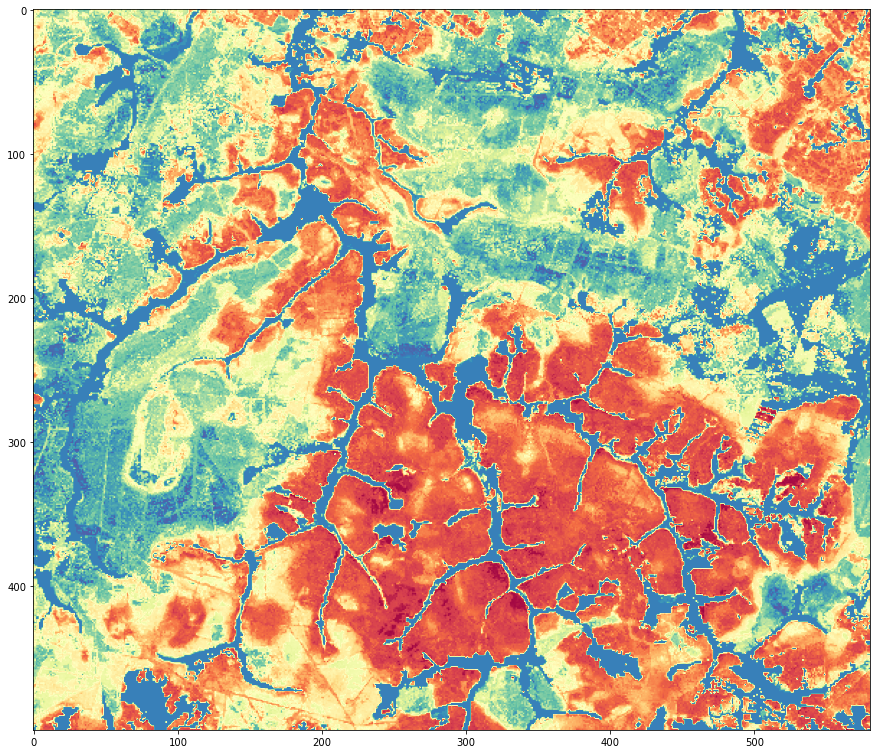

In [148]:
## Plotting the predicted map
fig, axs = plt.subplots(figsize=(15,15))
plt.imshow(clay_prediction, cmap = 'Spectral')
plt.show()

In [140]:
## Saving the predicted image
img_directory = "C:/Users/FREY/Documents/clay_predicted_pcs.tif"
cols = img.shape[1]
rows = img.shape[0]

clay_prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(img_directory, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(clay_prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(img_directory))

Image saved to: C:/Users/FREY/Documents/clay_predicted_pcs.tif


#### I hope you enjoy this tutorial and happy learning!